The motivation behind this project was to expand my toolkit of statistical techniques. Additionally, I wanted to complete a robust analysis of a dataset without using a mahcine learning model. I think I achieved both of these goals and am quite satisfied with the results.


The data comes from the United States Department of Agriculture (USDA) Economic Research Service's (ERS) Food Environmental Atlas. The dataset has over 275 variables and offers a eclectic overview of the US population's relationship with food sources. The dataset has a diverse set of variables, ranging from the sales tax on soda to the number of berry farms. This allows me to test a variety of hypotheses, and use a variety of visualization and statistical techniques to test them.

The main thing I'll be looking at is the percent of households experiencing food insecurity. The USDA uses the following definition of food insecurity: 
> Food insecurity is the limited or uncertain availability of nutritionally adequate and safe foods or limited or uncertain ability to acquire acceptable foods in socially acceptable ways.

Main questions:
- Has the level of food insecurity changed?
- What are the factors correlated with food insecurity?

### What to include:

- SQL code
- 2 to 3 EDA graphs
- Both regression models
- 2-3 Stat tests
    * Motivations/need for stat test
    * Brief background of stat test
    * Stat test
    * Result of test
    * Analysis
- Write up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%run helper.py

In [2]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9, 9))
sns.set_style('darkgrid')

In [3]:
health = pd.read_csv('../data/interim/health.csv')
insecurity = pd.read_csv('../data/interim/insecurity.csv')
price = pd.read_csv('../data/interim/price_taxes.csv')
regression_long = pd.read_csv('../data/processed/regression_long.csv')
regression_short = pd.read_csv('../data/processed/regression_short.csv')
stores = pd.read_csv('../data/interim/stores.csv')
supp_county = pd.read_csv('../data/interim/supp_county.csv')

# EDA

Because the dataset only has food insecurity at the state level I had to group most of the datasets by states. 

Population data is always a good place to start, so I'll examine the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.

Text(0.5, 1.0, 'US Population Change (2010-2016)')

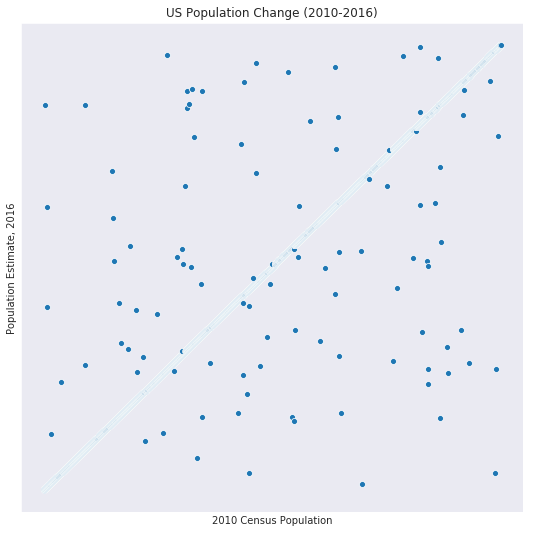

In [8]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])
plt.title('US Population Change (2010-2016)')

Looking at the types of stores and their may provide some insight on why some states have higher food insecurity. I created a seperate dataframe and populated the columns with the percent of the total number of stores that each store type has holds. Because Seaborn does not natively support a stacked barplot I had to manually arrange the store types. Other options, like matplotlib or R's ggplot2, offer greater flexibility at the cost of being more verbose.

In [4]:
stores_breakdown = pd.DataFrame()
summed_stores = stores.groupby(['State']).sum()

# creating totals
stores_breakdown['total14'] = summed_stores['GROC14'] + summed_stores['SUPERC14'] + summed_stores['CONVS14'] + summed_stores['SPECS14']

stores_list = ['GROC14',
              'SUPERC14',
              'CONVS14',
              'SPECS14']

for stores_type in stores_list:
    stores_breakdown[stores_type + '_pct'] = summed_stores[stores_type]/stores_breakdown['total14']*100

stores_breakdown.index.name = 'state'
stores_breakdown.reset_index(inplace=True)

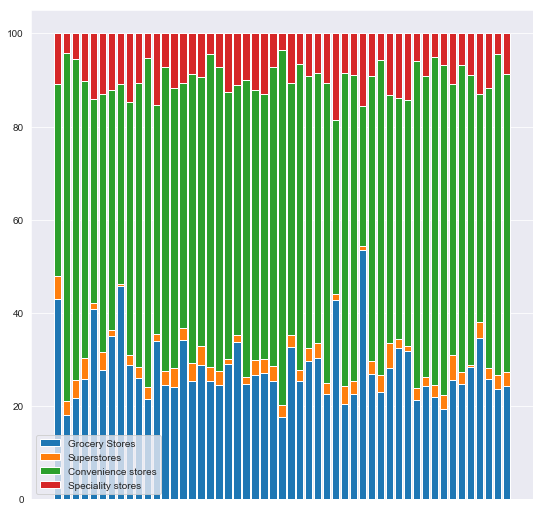

In [5]:
plt.bar(stores_breakdown['state'], stores_breakdown['GROC14_pct'], label='Grocery Stores')
plt.bar(stores_breakdown['state'], stores_breakdown['SUPERC14_pct'], bottom=stores_breakdown['GROC14_pct'], label='Superstores')
plt.bar(stores_breakdown['state'], stores_breakdown['CONVS14_pct'], bottom=stores_breakdown['GROC14_pct'] + stores_breakdown['SUPERC14_pct'], label='Convenience stores')
plt.bar(stores_breakdown['state'], stores_breakdown['SPECS14_pct'], bottom=stores_breakdown['GROC14_pct'] + stores_breakdown['SUPERC14_pct'] + stores_breakdown['CONVS14_pct'], label='Speciality stores')

plt.xticks([])
plt.legend()

A correlation plot of the insecurity data. We have essential 3 variables: food insecurity, very low food insecurity and child food insecurity. I'd expect food insecurity to be highly correlated very low food security and child food insecurity. FIPS should have no correlation with any variable, I don't think that there is a correlation with alphabetical order and food insecurity.

Looking at the plots as expected FIPS seems to be uncorrelated with all the other variables. also unsuprisingly we see that the same variables taken at different times are the most highly correlated. All correlations are either positive or uncorrelated. Food insecurity has a stronger positive correlation with very low security than it does with child food security.

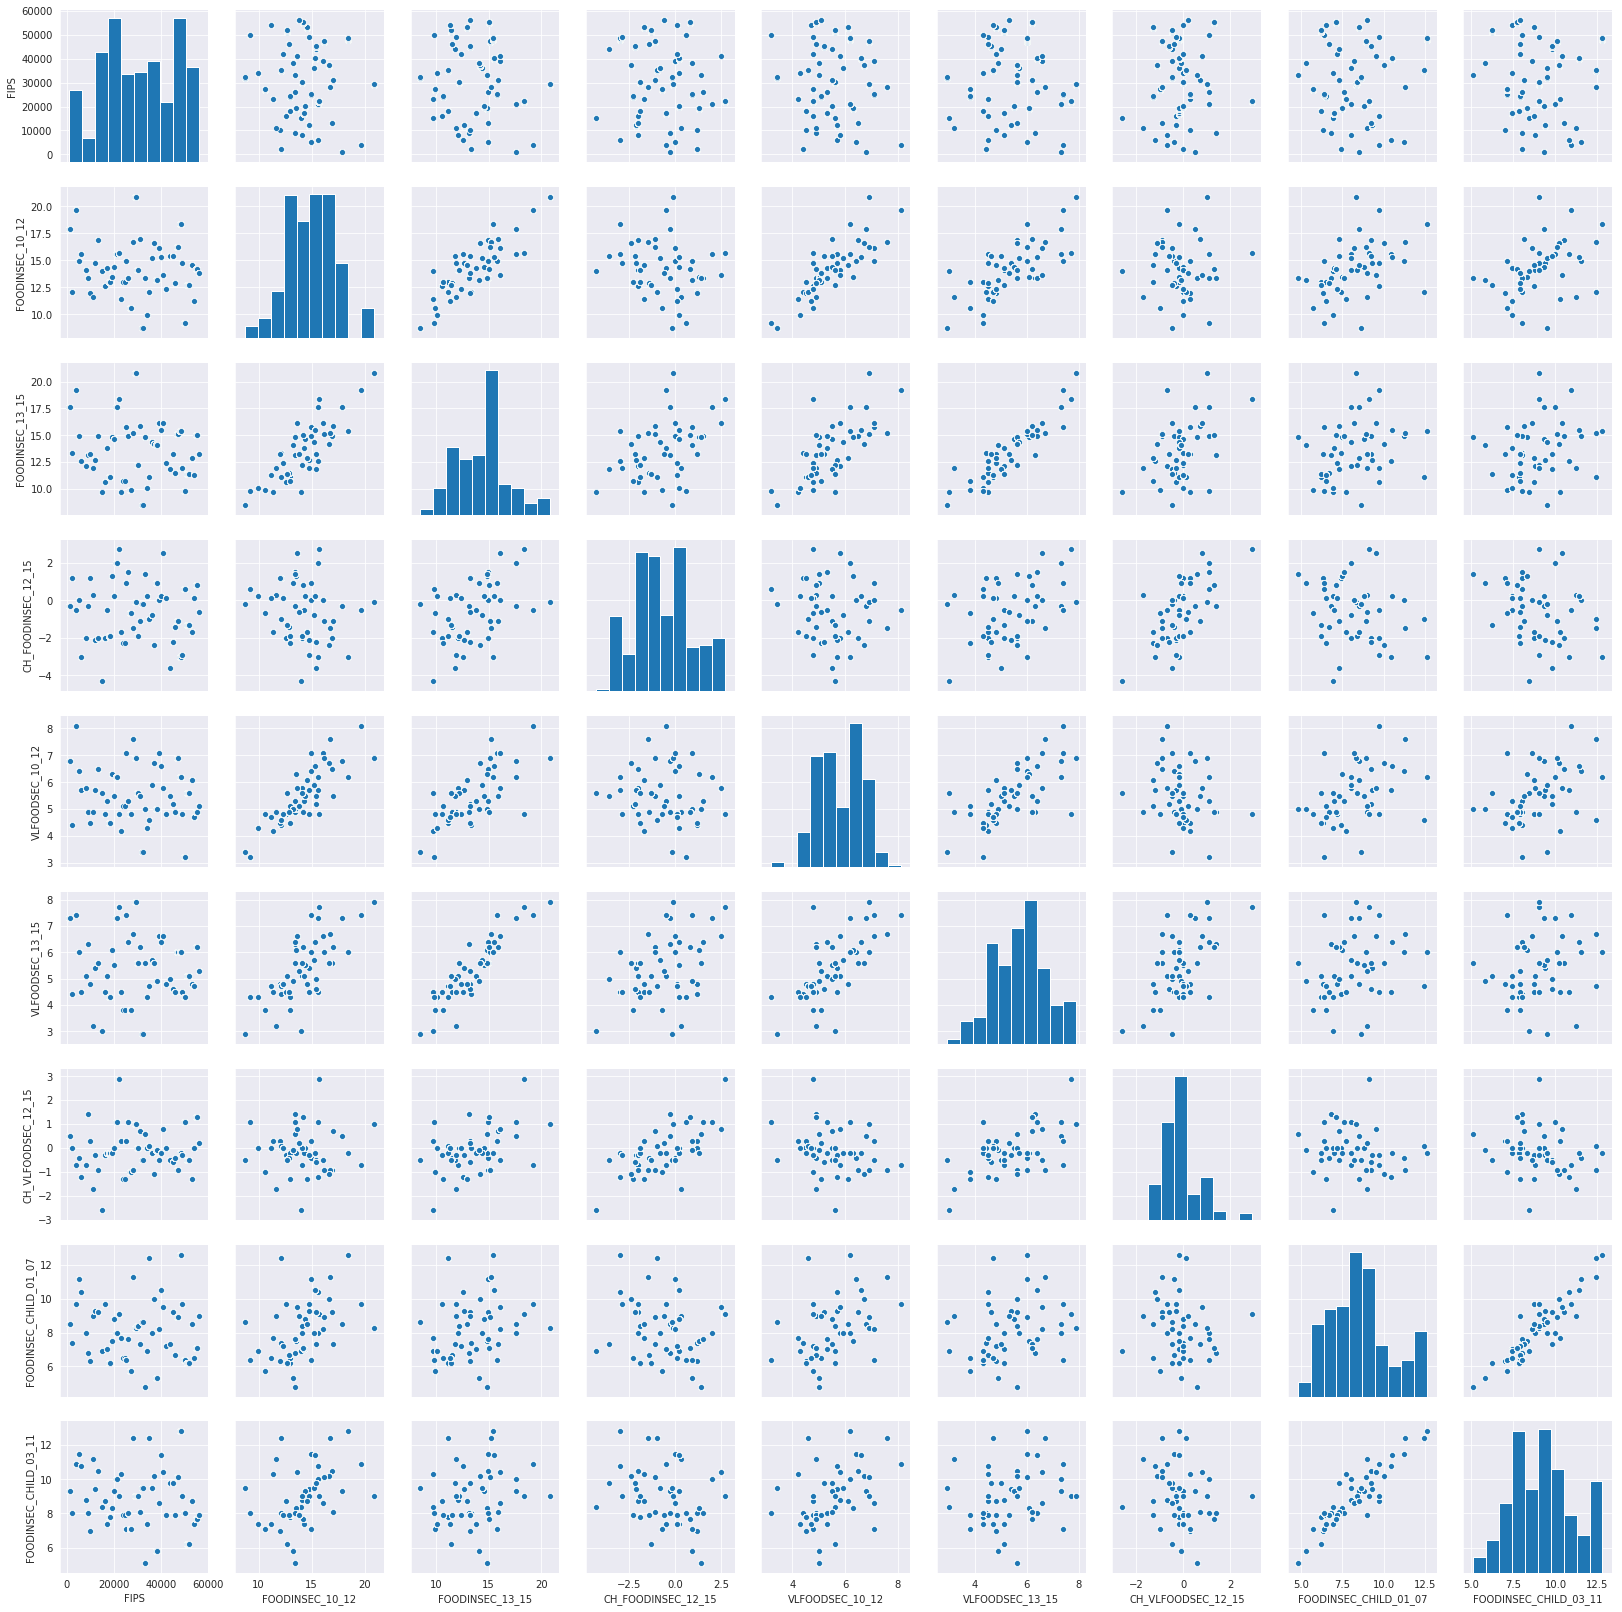

In [11]:
sns.pairplot(insecurity)

This messy looking code reduces the dataframe to 1 observation per state and returns only the states that have had a increase in food insecurity from 2010 to 2015. 17 states including the District of Columbia saw a increase in food insecurity, 2 states saw no change and 31 states had a decrease in food insecurity.

In [8]:
insecurity.groupby(['State']).head(1)[insecurity['CH_FOODINSEC_12_15'] > 0]

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,FIPS,State,County,FOODINSEC_10_12,FOODINSEC_13_15,CH_FOODINSEC_12_15,VLFOODSEC_10_12,VLFOODSEC_13_15,CH_VLFOODSEC_12_15,FOODINSEC_CHILD_01_07,FOODINSEC_CHILD_03_11
67,2013,AK,Aleutians East,12.1,13.3,1.2,4.4,4.4,0.0,7.4,8.0
316,10001,DE,Kent,12.0,13.2,1.2,4.5,4.8,0.3,6.3,7.0
319,11001,DC,District of Columbia,11.6,11.9,0.3,4.9,3.2,-1.7,9.0,11.2
789,19001,IA,Adair,13.5,14.8,1.3,6.3,6.1,-0.2,7.5,8.3
888,20001,KS,Allen,14.4,14.6,0.2,5.5,5.5,0.0,8.8,9.3
993,21001,KY,Adair,15.6,17.6,2.0,6.2,7.3,1.1,8.0,10.0
1113,22001,LA,Acadia,15.7,18.4,2.7,4.8,7.7,2.9,9.1,9.0
1217,25001,MA,Barnstable,14.9,15.8,0.9,7.1,7.4,0.3,6.4,7.1
1231,26001,MI,Alcona,13.4,14.9,1.5,5.3,6.4,1.1,7.6,8.0
1764,33001,NH,Belknap,13.4,14.8,1.4,5.0,5.6,0.6,4.8,5.1


([], <a list of 0 Text xticklabel objects>)

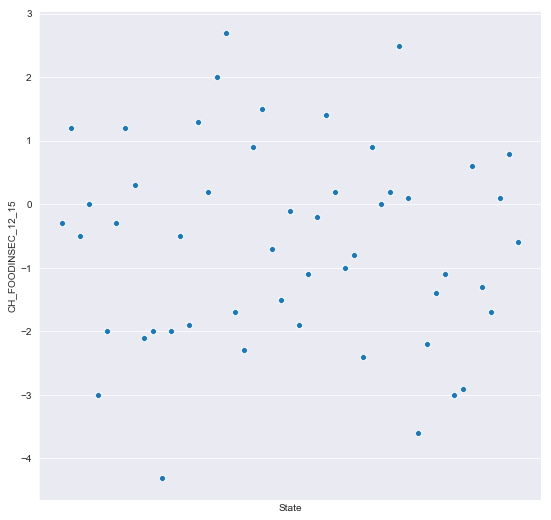

In [7]:
sns.scatterplot(x='State', y='CH_FOODINSEC_12_15', data=insecurity)
plt.xticks([])

# Statistical Tests

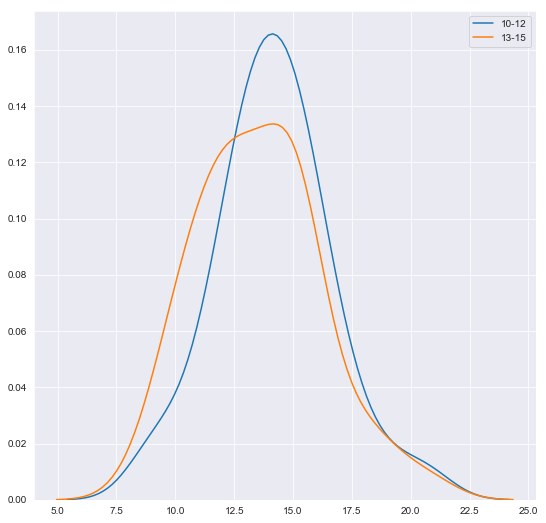

In [6]:
sns.kdeplot(regression_short['state_FOODINSEC_10_12'], label='10-12')
sns.kdeplot(regression_short['state_FOODINSEC_13_15'], label='13-15')
plt.legend()

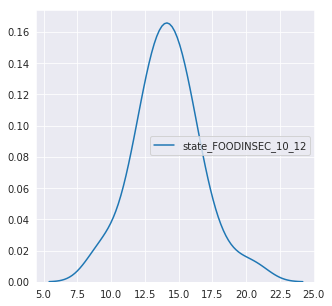

Sharpio-Wilk Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9871, p=0.8493
Fail to reject H0, normally distributed


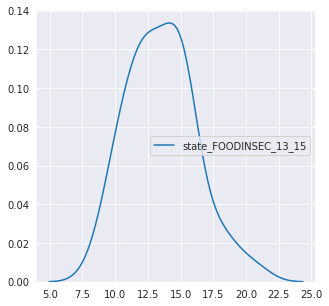

Sharpio-Wilk Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed

D'Agostino Test:
Statistic=0.9777, p=0.4450
Fail to reject H0, normally distributed


In [44]:
test_normality(regression_short, 'state_FOODINSEC_10_12')
test_normality(regression_short, 'state_FOODINSEC_13_15')

In [45]:
stats.ttest_rel(regression_short['state_FOODINSEC_10_12'],
                regression_short['state_FOODINSEC_13_15'])

Ttest_relResult(statistic=2.878865632380211, pvalue=0.005858791185468704)

In [ ]:
stats.levene(regression_short['state_FOODINSEC_10_12'],
             regression_short['state_FOODINSEC_13_15'], center='mean')

levene test does not assume normality

fail to reject null, variance are the same.

Overall mean changes, but variance remains. this is both good and bad.

# Regression